# PyTorch Workflow

Explore an end-to-end PyTorch workflow

In [66]:
whats_covered = {1: "data(prepare and load)",
                 2: "build model",
                 3: "fitting the model to data (training)",
                 4: "making predictions and evaluating the model (inference)",
                 5: "saving and loading the model",
                 6: "putting it all together"}

In [67]:
import torch
from torch import nn #nn contains all of pytorch building blocks for nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

## 1. Data (preparing and loading)

Data can be almost anything in ML

* Excel spreadhseets (rows,columns)
* Images of any kind
* Videos (youtube has lots of data)
* Audio like songs and podcasts
* DNA
* text

MAchine learning is a game of two parts:

1. Get data into a numerical representation.
2. Build a model to find patterns in that numerical representation.

To showcase this, let's create some *known* data using Linear regression formula.

We will use a linear regression formula to make a straight line with *known* **parameters**.



In [68]:
## We will start with a data creation (where we KNOW the parameteres)!
## once we get our X and y, we will try to build a ML model which will learn the
## known parameters by itself!

#Create known parameters

weight = 0.7
bias = 0.3

#Create some data

start = 0
end = 1
step =0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) #X is a tensor eventually #unsqueezed adds an extra dimension
y = weight* X + bias

X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [69]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

Generalization: the ability of an ML model to perform well on data it hasn't seen before

Training set (~ 60-80%)
Validation set (~ 10-20%) [OPTIONAL]
Testing set (~ 10-20%)

In [70]:
#create a train test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

### How might we better vizualize our data?

In [71]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """ Plots training and test data and compares predictions"""
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  #Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  #are there predictions?
  if predictions is not None:
    #plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="predictions")

  #show the legends
  plt.legend(prop={"size": 14});

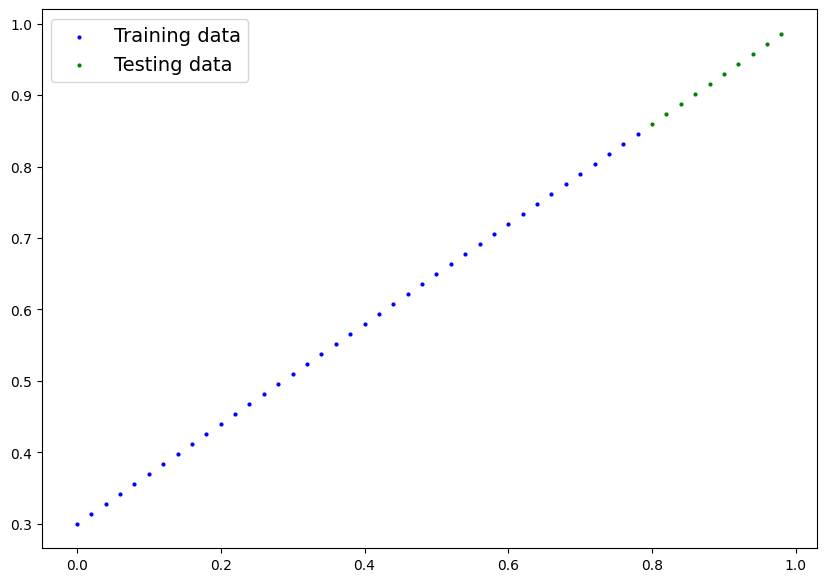

In [72]:
plot_predictions()

## 2. Building our first PyTorch model

What our model does?
* Start with random values of weights and bias
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values(the weights and bias values we used to create the data)

How does it do so?

Through 2 main algorithms
1. Gradient Descent: https://www.youtube.com/watch?v=IHZwWFHWa-w&ab_channel=3Blue1Brown
2. Backpropagation: https://www.youtube.com/watch?v=Ilg3gGewQ5U&ab_channel=3Blue1Brown

In [73]:
# Create a linear regression model class
##nn.Module is like lego building blocks for all models
##randn is random numbers from a NORMAL DISTRIBUTION!
class LinearRegressionModel(nn.Module): #almost everything in pytorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, #start with a random weight value and try to adjust it to ideal weight
                                            requires_grad=True, #can this param be updated via gradient descent?
                                            dtype=torch.float)) #pytoch loves float32 datatype
    self.bias = nn.Parameter(torch.randn(1,
                                        requires_grad = True,
                                        dtype=torch.float))

  #Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: #"x" is the input data
    return self.weights * x + self.bias #this is the linear regression formula



### PyTorch model building essentials
* torch.nn - contains all of the building blocks for computational graphs (a NN can be considered a computational graph)
* torch.nn.Parameter - what parameters shuld our mdoel try and learn (often a PyTorch layer from torch.nn will set these for us)
* torch.nn.Module - The base case for all NN modules. If you subclass it, you *need to** overwrite forward
* torch.optim - this is where the optimizers in pytorch live, they help with gradient descent
* def forward() - all nn.Module subclasses require you to overwrite forward. This method defines what happens in the forward computation.
* torch.utils.data.Dataset - represents a map between key(label) and sample(features) pairs of your data. Such as images and their associated labels.
* torch.utils.data.DataLoader - create a python iterable over a torch Dataset (allows you to iterate over your data)

### Checking the contents of our PyTorch model
We can check our model parameters or what's inside our model using .parameters()


In [74]:
# create a random seed
torch.manual_seed(42)

#create an instance of the model we created (this is a sublass of nn.Module)
model_0 = LinearRegressionModel()

#check out parameters
model_0.parameters(), list(model_0.parameters())

(<generator object Module.parameters at 0x7b2b96188120>,
 [Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)])

In [75]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [76]:
#our goal is to get as close to orig weight(0.7), bias(0.3)

### Making predictions using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts `y_test` based on `x_test`.
When we pass data through our model, it's going to run it through the `forward()` method.

In [77]:
# make predictions with model
#inference mode turns off the gradient tracking!!
#(we dont need to keep track of how to update the model using inference)
# Inference mode disables these extra things used while training, hence pytorch will keep track of less data
#predictions will be a lot faster in inference mode, because so much data is not tracked
with torch.inference_mode(): #this is context manager, we could also get y_preds = model_0(X_test)! (see below, it still has gradient tracking)
  y_preds = model_0(X_test)


#similar to inference mode, however inference_mode() is preferred
# with torch.no_grad():
#    y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [78]:
y_preds_no_inf_mode = model_0(X_test)
y_preds_no_inf_mode

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

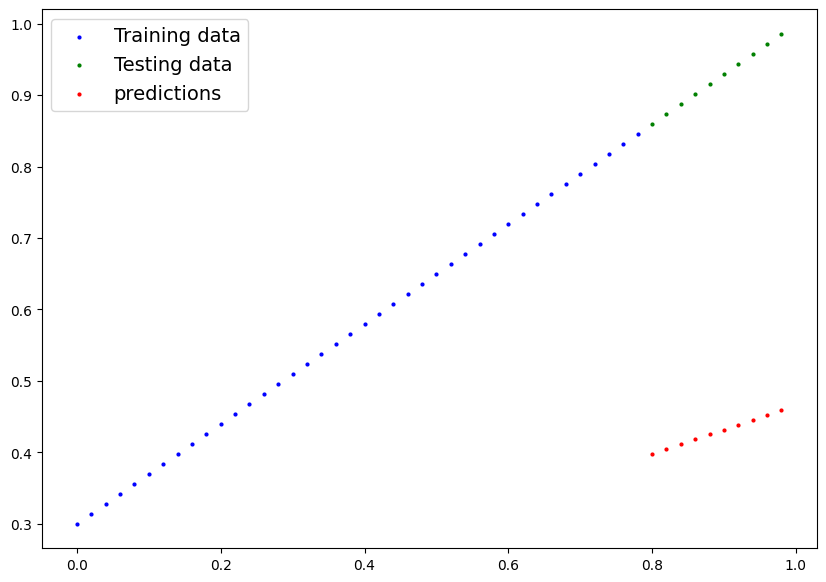

In [79]:
plot_predictions(predictions=y_preds)

## 3. Train models

The whole idea of training is for model to move from some unknown parameters (maybe random) to some known parameters.
Or in other words from a poor representation of data to a better representation of data.

One way to measure how poor or wrong your model predictions are is to use a loss function.
* Note : Loss function may also be called cost function or criterion in different areas.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs. (the lower the better!).
* **Optimizer:** Takes into account the loss of the model and adjusts the model's parameters (eg: weights and bias) to improve the loss function.

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [80]:
#check out our model's parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [81]:
# Setup a loss function
loss_fn = nn.L1Loss() #mean absolute error(MAE) same as torch.mean(torch.abs(y_pred-y_test))

# Setup an optimizer
## we will pick SGD (stochastic(random) gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), #params: the model params you would like to optimize
                            lr=0.01) #learning rate = possibly the most important hyperparameter

In [82]:
loss_fn

L1Loss()

### Building a training loop (and a testing loop) in PyTorch

Typical steps we need to create a training loop:
0. Loop through the data and do steps 1-5
1. Foward pass (this involves data moving through our model's `forward()` functions) [Also called forward propagation]
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimzer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss. [**Back Propagation**]
5. Optimizer step - use the optimizer to adjust our model's parameters to try and imporve the loss [**Gradient descent**]

In [83]:
torch.manual_seed(42)
#An epoch is one loop through the data
## this is a hyperparameter because we set it ourselves
epochs = 200

### Training
#0.loop through the data
for epoch in range(epochs):
  # set the model to training mode (default state of the model)
  #train mode in PyTorch sets all parameters that require gradients (require_grad true) to require gradients
  model_0.train()
  # model_0.eval() #turns off gradient tracking

  #1. forward pass (calls the forward() method inside)
  y_pred = model_0(X_train)

  #2. Calculate the loss (how different are the model's predictions to the true values)
  loss = loss_fn(y_pred, y_train)
  print(f"loss {loss}")

  #3. Optimizer zero grad (gradients accumulate by default, so we zero it)
  optimizer.zero_grad()

  #4. Perform back propagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimzer (perform gradient descent)
  """#by default hpw the optimizer changes will accumulate through the loop,
  so we have to zero them in step 3 above for the next iteration of the loop"""
  #check torch autograd
  #check learning rate scheduling
  optimizer.step()

  ###Testing
  model_0.eval()

  #Print out model state_dict()
  print(model_0.state_dict())


loss 0.31288138031959534
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
loss 0.3013603389263153
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
loss 0.28983935713768005
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
loss 0.2783183455467224
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
loss 0.26679736375808716
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
loss 0.2552763521671295
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
loss 0.24375534057617188
OrderedDict([('weights', tensor([0.3640])), ('bias', tensor([0.1988]))])
loss 0.23223432898521423
OrderedDict([('weights', tensor([0.3679])), ('bias', tensor([0.2088]))])
loss 0.22071333229541779
OrderedDict([('weights', tensor([0.3718])), ('bias', tensor([0.2188]))])
loss 0.20919232070446014
OrderedDict([('weights', tensor([0.3757])), ('bias', tensor([0.2288]))])
loss 0.1976713240146637

In [84]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

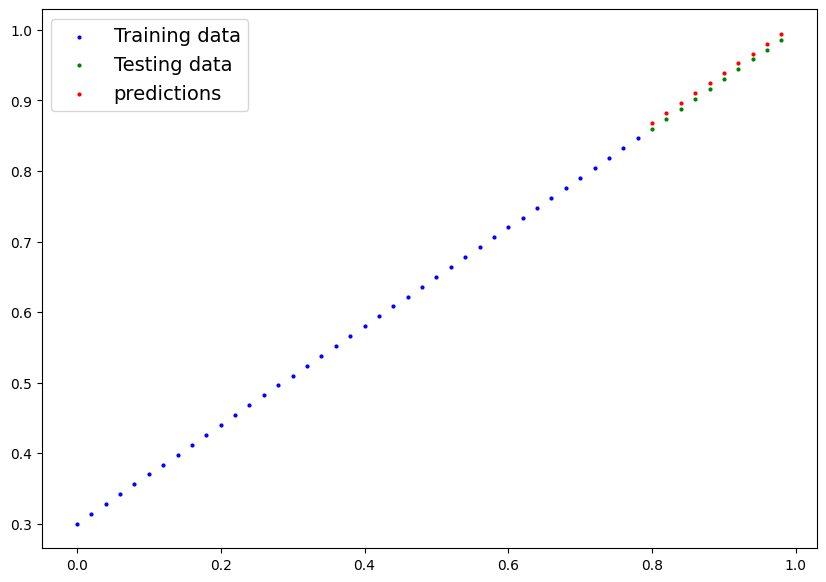

In [85]:
plot_predictions(predictions=y_preds_new)

In [86]:
#resetting the model
model_0= LinearRegressionModel()
optimizer = torch.optim.SGD(params=model_0.parameters(), #params: the model params you would like to optimize
                            lr=0.01)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [87]:
#### WRITE THE TESTING LOOPPPPPPPPPPP

In [88]:
torch.manual_seed(42)
#An epoch is one loop through the data
## this is a hyperparameter because we set it ourselves
epochs = 2000

### Training
#0.loop through the data
for epoch in range(epochs):
  # set the model to training mode (default state of the model)
  #train mode in PyTorch sets all parameters that require gradients (require_grad true) to require gradients
  model_0.train()
  # model_0.eval() #turns off gradient tracking

  #1. forward pass (calls the forward() method inside)
  y_pred = model_0(X_train)

  #2. Calculate the loss (how different are the model's predictions to the true values)
  loss = loss_fn(y_pred, y_train)
  # print(f"loss {loss}")

  #3. Optimizer zero grad (gradients accumulate by default, so we zero it)
  optimizer.zero_grad()

  #4. Perform back propagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimzer (perform gradient descent)
  """#by default hpw the optimizer changes will accumulate through the loop,
  so we have to zero them in step 3 above for the next iteration of the loop"""
  #check torch autograd
  #check learning rate scheduling
  optimizer.step()

  ###Testing
  model_0.eval()  #turns off different settings in model not needed for evaluation/testing (droppout/batchnorm layers)
  #with torch.no_grad() is also valid, but inefrence mode is nograd on steroids
  with torch.inference_mode(): #turns off grad tracking etc
    # 1. Do the forward pass in testing mode
    test_pred = model_0(X_test)

    #2.Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  #Print whats happening
  if epoch % 100 ==0:
    print(f"Epock {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    #Print out model state_dict()
    print(model_0.state_dict())

Epock 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epock 100 | Loss: 0.024458957836031914 | Test Loss: 0.05646304413676262
OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])
Epock 200 | Loss: 0.008932482451200485 | Test Loss: 0.005023092031478882
OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])
Epock 300 | Loss: 0.008932482451200485 | Test Loss: 0.005023092031478882
OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])
Epock 400 | Loss: 0.008932482451200485 | Test Loss: 0.005023092031478882
OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])
Epock 500 | Loss: 0.008932482451200485 | Test Loss: 0.005023092031478882
OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])
Epock 600 | Loss: 0.008932482451200485 | Test Loss: 0.005023092031478882
OrderedDict([('weights', tensor([0.6951])), ('bias', ten

In [89]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [90]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

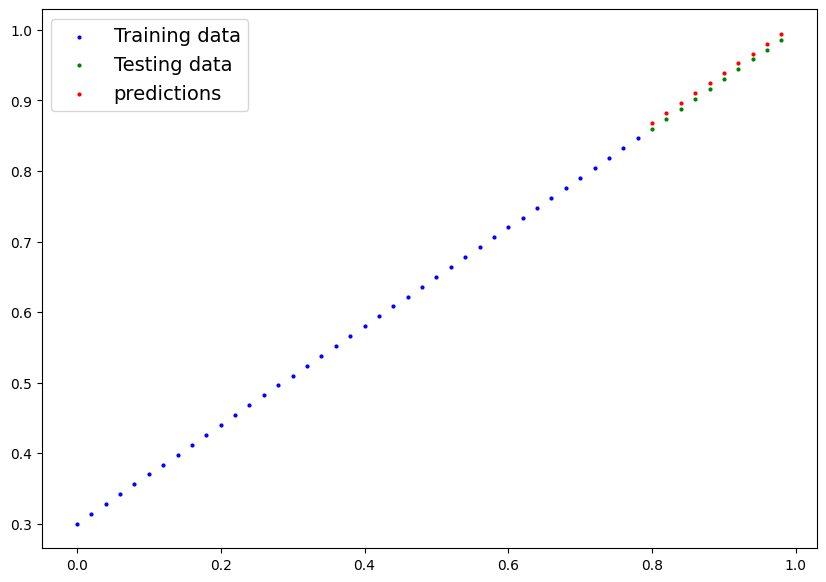

In [91]:
plot_predictions(predictions=y_preds_new)

#### Model tracking

In [92]:
#resetting the model
model_0= LinearRegressionModel()
optimizer = torch.optim.SGD(params=model_0.parameters(), #params: the model params you would like to optimize
                            lr=0.01)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [93]:
torch.manual_seed(42)
#An epoch is one loop through the data
## this is a hyperparameter because we set it ourselves
epochs = 200

#Track different values
epoch_counts =[]
loss_values=[]
test_loss_values=[]

### Training
#0.loop through the data
for epoch in range(epochs):
  # set the model to training mode (default state of the model)
  #train mode in PyTorch sets all parameters that require gradients (require_grad true) to require gradients
  model_0.train()
  # model_0.eval() #turns off gradient tracking

  #1. forward pass (calls the forward() method inside)
  y_pred = model_0(X_train)

  #2. Calculate the loss (how different are the model's predictions to the true values)
  loss = loss_fn(y_pred, y_train)
  # print(f"loss {loss}")

  #3. Optimizer zero grad (gradients accumulate by default, so we zero it)
  optimizer.zero_grad()

  #4. Perform back propagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimzer (perform gradient descent)
  """#by default hpw the optimizer changes will accumulate through the loop,
  so we have to zero them in step 3 above for the next iteration of the loop"""
  #check torch autograd
  #check learning rate scheduling
  optimizer.step()

  ###Testing
  model_0.eval()  #turns off different settings in model not needed for evaluation/testing (droppout/batchnorm layers)
  #with torch.no_grad() is also valid, but inefrence mode is nograd on steroids
  with torch.inference_mode(): #turns off grad tracking etc
    # 1. Do the forward pass in testing mode
    test_pred = model_0(X_test)

    #2.Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  #Print whats happening
  if epoch % 10 ==0:
    epoch_counts.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epock {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    #Print out model state_dict()
    print(model_0.state_dict())

Epock 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epock 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epock 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epock 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epock 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epock 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epock 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

In [94]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

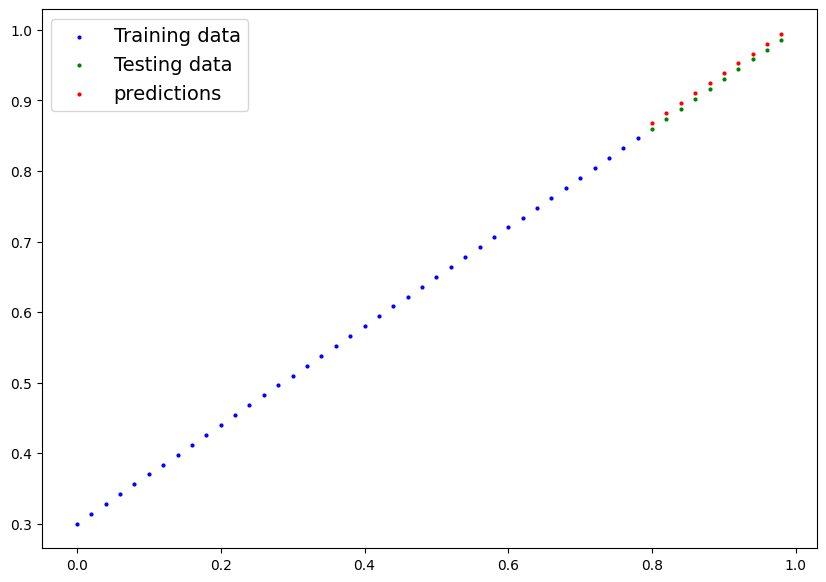

In [95]:
plot_predictions(predictions=y_preds_new)

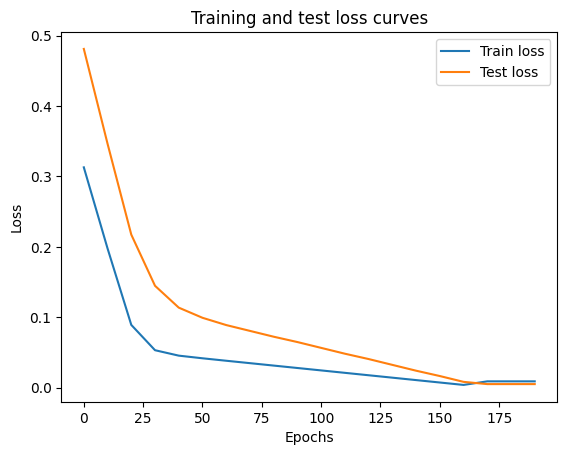

In [96]:
#Plot the loss curves
plt.plot(epoch_counts, torch.tensor(loss_values).cpu().numpy(), label = "Train loss")
plt.plot(epoch_counts, torch.tensor(test_loss_values).cpu().numpy(), label = "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

### Saving a model
There are 3 main methods for saving and loading models in PyTorch.
1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows you to load a model's saved state dictionary

In [97]:
# Saving our PyTorch model

from pathlib import Path

#1. Create a model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create a model save path
MODEL_NAME = "ZTM_01_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

#3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/ZTM_01_model_0.pth


In [98]:
!ls -l models

total 8
-rw-r--r-- 1 root root 1720 Mar 20 17:31 01_LINEAR_MULTI_model_1.pth
-rw-r--r-- 1 root root 1538 Mar 20 17:37 ZTM_01_model_0.pth


### Loading a model

Since we saved our model's state_dict() rather than the entire model, we will create a new instance of our model class and load saved state_dict() into that.

In [99]:
#instantiate a new instance of our model class, to load saved state_dict

loaded_model_0= LinearRegressionModel()

print(loaded_model_0.state_dict())

#Load the saved state dict of model_0 (this will upadte the new instance with updated params)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(loaded_model_0.state_dict())

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])


In [100]:
#Make some predictions with the loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds


tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [101]:
#compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

In [102]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'2.2.1+cu121'

In [103]:
#Create device agnostic code (use gpu if available for faster computing, default to cpu)
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"using device {device}")

using device cuda


In [104]:
!nvidia-smi

Wed Mar 20 17:37:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              35W /  70W |    159MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

###6.1 Data

In [105]:
#Create some dummy data using linear regression formula of y=weight*features+bias
weights= torch.Tensor([[0.1, 0.2]])
bias=0.1

#create range values
start = 0
end = 2
step = 0.02

#create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
X=X.reshape(50,-1)
y= torch.mm(X, weights.T) + bias
X[:10], y[:10]

(tensor([[0.0000, 0.0200],
         [0.0400, 0.0600],
         [0.0800, 0.1000],
         [0.1200, 0.1400],
         [0.1600, 0.1800],
         [0.2000, 0.2200],
         [0.2400, 0.2600],
         [0.2800, 0.3000],
         [0.3200, 0.3400],
         [0.3600, 0.3800]]),
 tensor([[0.1040],
         [0.1160],
         [0.1280],
         [0.1400],
         [0.1520],
         [0.1640],
         [0.1760],
         [0.1880],
         [0.2000],
         [0.2120]]))

In [106]:
#splitting the data
train_split=int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train),len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [107]:
X_train[:,1]

tensor([0.0200, 0.0600, 0.1000, 0.1400, 0.1800, 0.2200, 0.2600, 0.3000, 0.3400,
        0.3800, 0.4200, 0.4600, 0.5000, 0.5400, 0.5800, 0.6200, 0.6600, 0.7000,
        0.7400, 0.7800, 0.8200, 0.8600, 0.9000, 0.9400, 0.9800, 1.0200, 1.0600,
        1.1000, 1.1400, 1.1800, 1.2200, 1.2600, 1.3000, 1.3400, 1.3800, 1.4200,
        1.4600, 1.5000, 1.5400, 1.5800])

In [108]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """ Plots training and test data and compares predictions"""
  fig=plt.figure(figsize=(10,7))
  ax = fig.add_subplot(111, projection='3d')


  # Plot training data in blue
  ax.scatter(train_data[:,0],train_data[:,1], train_labels, c="b", s=4, label="Training data")

  #Plot test data in green
  ax.scatter(test_data[:,0],test_data[:,1], test_labels, c="g", s=4, label="Testing data")

  #are there predictions?
  if predictions is not None:
    #plot the predictions if they exist
    ax.scatter(test_data[:,0],test_data[:,1], predictions, c="r", s=4, label="predictions")

  #show the legends
  plt.legend(prop={"size": 14});

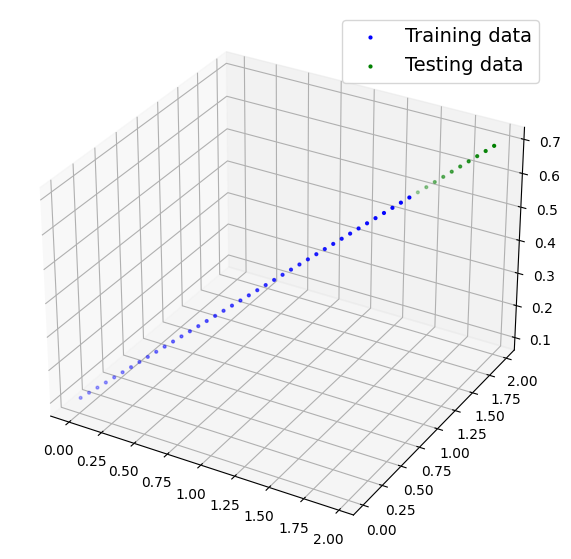

In [109]:
plot_predictions()

### 6.2 Building a PyTorch Linear model

In [110]:
#create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model params (ALSO called linear transform, probing layer, fully connected layer, dense layer)
    # self.linear_layer = nn.Linear(in_features=1, out_features=1) [FOR ORIGINAL MODEL]
    self.linear_layer = nn.Linear(in_features=2, out_features=1) #performs y=x(A^T)+b

  def forward(self, x:torch.Tensor)->torch.Tensor:
    return self.linear_layer(x)

#Set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5406, 0.5869]])),
             ('linear_layer.bias', tensor([-0.1657]))])

In [111]:
model_1

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=2, out_features=1, bias=True)
)

In [112]:
#check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [113]:
#set the model to use the target device
model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=2, out_features=1, bias=True)
)

In [114]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [115]:
model_1.state_dict()

OrderedDict([('linear_layer.weight',
              tensor([[0.5406, 0.5869]], device='cuda:0')),
             ('linear_layer.bias', tensor([-0.1657], device='cuda:0'))])

###6.3 Training code

For training, we need loss function, optimizer, training loop and a testing loop

In [116]:
#setup loss function
loss_fn = nn.L1Loss() #MAE

#setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)


In [117]:
#Training loop
torch.manual_seed(42)
epochs=200

#Put data on target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  #1.Forward pass
  y_pred = model_1(X_train)

  #2.Calculate the loss
  train_loss = loss_fn(y_pred, y_train)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Back propagation
  train_loss.backward()

  #5.Optimizer step
  optimizer.step()

  ###Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  #Print whats happening
  if epoch%10==0:
    print(f"Epoch {epoch} | Train loss: {train_loss} | Test loss: {test_loss}")


Epoch 0 | Train loss: 0.4443700313568115 | Test loss: 1.1829233169555664
Epoch 10 | Train loss: 0.3216521441936493 | Test loss: 0.8868573307991028
Epoch 20 | Train loss: 0.23642058670520782 | Test loss: 0.6406740546226501
Epoch 30 | Train loss: 0.18678174912929535 | Test loss: 0.4593164622783661
Epoch 40 | Train loss: 0.16142326593399048 | Test loss: 0.34391751885414124
Epoch 50 | Train loss: 0.14628782868385315 | Test loss: 0.2787555754184723
Epoch 60 | Train loss: 0.13373534381389618 | Test loss: 0.24021565914154053
Epoch 70 | Train loss: 0.12154383957386017 | Test loss: 0.21783149242401123
Epoch 80 | Train loss: 0.10938148945569992 | Test loss: 0.19544725120067596
Epoch 90 | Train loss: 0.09721698611974716 | Test loss: 0.1730630248785019
Epoch 100 | Train loss: 0.08504422008991241 | Test loss: 0.1506788432598114
Epoch 110 | Train loss: 0.07287272065877914 | Test loss: 0.13060250878334045
Epoch 120 | Train loss: 0.06071038171648979 | Test loss: 0.10821832716464996
Epoch 130 | Train l

In [118]:
model_1.state_dict() #IDEAL weights= torch.Tensor([[0.1, 0.2]]) bias=0.1

OrderedDict([('linear_layer.weight',
              tensor([[0.1246, 0.1761]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.0918], device='cuda:0'))])

###6.4 Making and evaluating predictions

In [119]:
model_1.eval()
with torch.inference_mode():
  y_preds=model_1(X_test).to(device)
y_preds

tensor([[0.5764],
        [0.5885],
        [0.6005],
        [0.6125],
        [0.6245],
        [0.6366],
        [0.6486],
        [0.6606],
        [0.6726],
        [0.6847]], device='cuda:0')

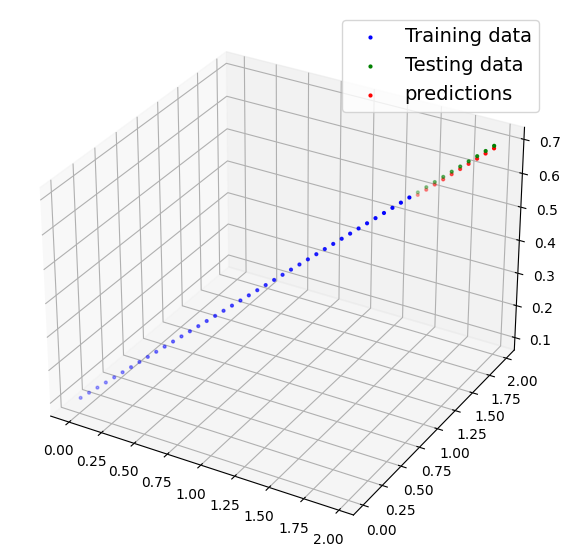

In [120]:
plot_predictions(predictions=y_preds.to("cpu"))

### 6.5 Saving and loading a trained model

In [121]:
from pathlib import Path

#1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2.Create model save path
MODEL_NAME = "01_LINEAR_MULTI_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

#3. Save the mdoel state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)


Saving model to models/01_LINEAR_MULTI_model_1.pth


In [122]:
#Load a pytorch model

#create a new instance of the model
loaded_model_1 = LinearRegressionModelV2()

#load the saved model_1 state dict
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

#Put the target model to the device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=2, out_features=1, bias=True)
)

In [123]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [124]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight',
              tensor([[0.1246, 0.1761]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.0918], device='cuda:0'))])

In [125]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_y_preds = loaded_model_1(X_test)
loaded_y_preds


tensor([[0.5764],
        [0.5885],
        [0.6005],
        [0.6125],
        [0.6245],
        [0.6366],
        [0.6486],
        [0.6606],
        [0.6726],
        [0.6847]], device='cuda:0')

In [126]:
y_preds == loaded_y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')